# TurboPy tutorial

This notebook shows an example app simulating the motion of a block on a spring using the turboPy framework. This app will estimate the position and momentum over time of a block attached to a spring.

The equations of motion for a block on a spring are
\begin{equation*}
\frac{dx}{dt} = \frac{p}{m}, \\
\frac{dp}{dt} = - k x,
\end{equation*}
where $m$ is the mass of the block, and $k$ is the spring constant.

In order to solve these equations, we will create a custom `PhysicsModule` which will store the parameters $m$ and $k$, and take care of updating the position and momentum of the block at each time step.

We first need to make the necessary imports:

In [1]:
from turbopy import Simulation, PhysicsModule, Diagnostic, CSVOutputUtility, ComputeTool
import numpy as np

We will also import matplotlib. This is not necessary to run the turboPy framework, but it will be used in this example for the sake of demonstration.

In [2]:
import matplotlib.pyplot as plt

Then create subclasses for the `PhysicsModule` and `Diagnostic` classes and override the necessary methods. These classes hold data necessary for the simulation that will be specified later.

In [3]:
class BlockOnSpring(PhysicsModule):
    """Use turboPy to compute the motion of a block on a spring"""

    def __init__(self, owner: Simulation, input_data: dict):
        super().__init__(owner, input_data)
        self.position = np.zeros((1, 3))
        self.momentum = np.zeros((1, 3))
        self.mass = input_data.get('mass', 1)
        self.spring_constant = input_data.get('spring_constant', 1)
        self.push = owner.find_tool_by_name(input_data["pusher"]).push

    def initialize(self):
        self.position[:] = np.array(self._input_data["x0"])

    def exchange_resources(self):
        self.publish_resource({"Block:position": self.position})
        self.publish_resource({"Block:momentum": self.momentum})

    def update(self):
        self.push(self.position, self.momentum,
                  self.mass, self.spring_constant)

In [4]:
class BlockDiagnostic(Diagnostic):
    def __init__(self, owner: Simulation, input_data: dict):
        super().__init__(owner, input_data)
        self.data = None
        self.component = input_data.get("component", 1)
        self.output_function = None
        self.csv = None

    def inspect_resource(self, resource):
        if "Block:" + self.component in resource:
            self.data = resource["Block:" + self.component]

    def diagnose(self):
        self.output_function(self.data[0, :])

    def initialize(self):
        # setup output method
        functions = {"stdout": self.print_diagnose,
                     "csv": self.csv_diagnose,
                     }
        self.output_function = functions[self._input_data["output_type"]]
        if self._input_data["output_type"] == "csv":
            diagnostic_size = (self._owner.clock.num_steps + 1, 3)
            self.csv = CSVOutputUtility(
                self._input_data["filename"],
                diagnostic_size)

    def finalize(self):
        self.diagnose()
        if self._input_data["output_type"] == "csv":
            self.csv.finalize()

    def print_diagnose(self, data):
        print(data)

    def csv_diagnose(self, data):
        self.csv.append(data)

Then we create a subclass of the `ComputeTool` class to implement the math behind the simulation. For this example, we'll be using the Leapfrog integration method. For each time step, the Leapfrog method first updates the position using the current position and momentum values. It then uses the updated position and time values to calculate the next momentum value.

\begin{equation*}
x_{n+1} = x_{n} + \Delta t * \frac{p_n}{m} \\
p_{n+1} = p_{n} - \Delta t * k * x_{n+1}
\end{equation*}

Where $x$ is the position, $p$ is the momentum, $\Delta t$ is the time step, $k$ is the spring constant, and $m$ is the mass of the block.

In [5]:
class Leapfrog(ComputeTool):
    """Implementation of the leapfrog algorithm"""

    def __init__(self, owner: Simulation, input_data: dict):
        super().__init__(owner, input_data)
        self.dt = None

    def initialize(self):
        self.dt = self._owner.clock.dt

    def push(self, position, momentum, mass, spring_constant):
        position[:] = position + self.dt * momentum / mass
        momentum[:] = momentum - self.dt * spring_constant * position

We need to add each of these new classes to the `_registry` attribute for their superclasses.

In [6]:
PhysicsModule.register("BlockOnSpring", BlockOnSpring)
Diagnostic.register("BlockDiagnostic", BlockDiagnostic)
ComputeTool.register("Leapfrog", Leapfrog)

The `Simulation` class takes a dictionary of input data as an argument, which contains all the necessary information for the simulation to run. The simulation is designed to save the outputs (time, position, momentum) to csv files using the `CSVOutputUtility` class. The `Diagnostics` keyword of the dictionary tells the simulation where to save the outputs.

In [7]:
input_data = {
    "Grid": {"N": 2, "x_min": 0, "x_max": 1},
    "Clock": {"start_time": 0,
              "end_time": 10,
              "num_steps": 100},
    "PhysicsModules": {
        "BlockOnSpring": {
            "mass": 1,
            "spring_constant": 1,
            "pusher": "Leapfrog",
            "x0": [0, 1, 0],
        }
    },
    "Tools": {
        "Leapfrog": {},
    },
    "Diagnostics": {
        # default values come first
        "directory": "output_leapfrog/",
        "output_type": "csv",
        "clock": {"filename": "time.csv"},
        "BlockDiagnostic": [
            {'component': 'momentum', 'filename': 'block_p.csv'},
            {'component': 'position', 'filename': 'block_x.csv'}
        ]
    }
}

Once everything is set up, running the simulation is simple.

In [8]:
sim = Simulation(input_data)
sim.run()

Simulation is initializing
Reading Grid...
Reading Tools...
Reading PhysicsModules...
Reading Diagnostics...
Initializing Simulation Clock...
Initializing Tools...
Initializing PhysicsModules...
Initializing Diagnostics...
Initialization complete
Simulation is started
Simulation complete


Since the simulation is not designed to plot the outputs directly, we'll have to set that up ourselves. After running the simulation, the ouputs are stored in the `buffer` variable by instances of the `CSVOutputUtility` class in each of the objects in the `diagnostics` list owned by the main simulation. For this simulation, the first item in the list is an instance of the `ClockDiagnostic` class which stores the time values, and the second and third items are instances of the `BlockDiagnostic` class created above. The second item stores the momentum values and the third item stores the position values.

In [9]:
print(sim.diagnostics)

[ClockDiagnostic({'directory': 'output_leapfrog/', 'output_type': 'csv', 'filename': 'output_leapfrog/time.csv', 'type': 'clock'}), BlockDiagnostic({'directory': 'output_leapfrog/', 'output_type': 'csv', 'component': 'momentum', 'filename': 'output_leapfrog/block_p.csv', 'type': 'BlockDiagnostic'}), BlockDiagnostic({'directory': 'output_leapfrog/', 'output_type': 'csv', 'component': 'position', 'filename': 'output_leapfrog/block_x.csv', 'type': 'BlockDiagnostic'})]


Now we can plot the data. For this example, we'll plot momentum over time, position over time, and momentum over position.

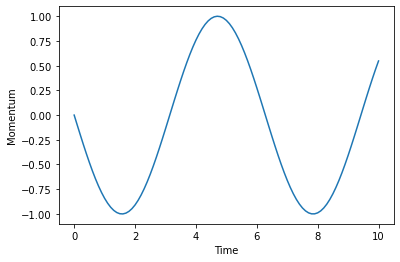

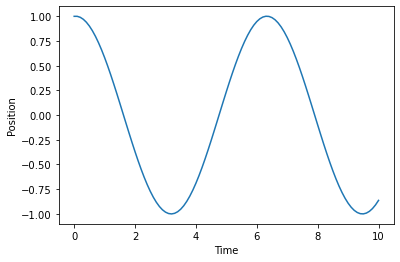

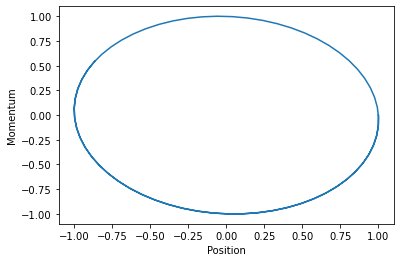

In [10]:
time = []
momentum = []
position = []

for i in sim.diagnostics[0].csv.buffer:
    time.append(i[0])

for i in sim.diagnostics[1].csv.buffer:
    momentum.append(i[1])

for i in sim.diagnostics[2].csv.buffer:
    position.append(i[1])

plt.plot(time, momentum)
plt.xlabel('Time')
plt.ylabel('Momentum')
plt.show()

plt.plot(time, position)
plt.xlabel('Time')
plt.ylabel('Position')
plt.show()

plt.plot(position, momentum)
plt.xlabel('Position')
plt.ylabel('Momentum')
plt.show()